# Index Creation, Charting, Simple Statistical Analysis and Connectedness

## Part 1: Loading the required libraries

In [1]:
%load_ext rpy2.ipython

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For better date formatting
import openpyxl
import numpy as np

from statsmodels.tsa.stattools import adfuller, kpss



Error importing in API mode: ImportError("dlopen(/Users/james/Documents/Git Hub/FinanceResearch/.venv/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/james/Documents/Git Hub/FinanceResearch/.venv/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%R

# This entire cell is now R code!
print("Hello from the R world, inside my Python notebook!")

# Let's load the library you installed to prove it works
library(ConnectednessApproach)

# Let's check our R version info
sessionInfo()

[1] "Hello from the R world, inside my Python notebook!"
R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin25.0.0
Running under: macOS Tahoe 26.0

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib 
LAPACK: /opt/homebrew/Cellar/r/4.5.1/lib/R/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] C.UTF-8/C.UTF-8/C.UTF-8/C/C.UTF-8/C.UTF-8

time zone: America/Monterrey
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ConnectednessApproach_1.0.4

loaded via a namespace (and not attached):
 [1] rmgarch_1.4-2                shape_1.4.6.1               
 [3] xfun_0.53                    ks_1.15.1                   
 [5] lattice_0.22-7               numDeriv_2016.8-1.1         
 [7] quadprog_1.5-8               vctrs_0.6.5                 
 [9] parallel_4.5.1               


Please cite as: 

 Gabauer, David (2022). ConnectednessApproach.
 R package version 1.0.0. https://CRAN.R-project.org/package=ConnectednessApproach 



## Part 2: Functions for loading in the prices from Refinitiv for each stock and to calculate our index.

### Function 2.A: Load and Prepare Refinitiv obtained company price data from each group.

In [3]:
def load_and_prepare_data(filepath, sheet_name):
    """
    Loads raw price data from a specific sheet in an Excel file.
    The expected format is repeating pairs of (Date, Price) columns for each company.
    """
    print(f"  - Reading sheet '{sheet_name}' from '{filepath}'...")
    try:
        df_raw = pd.read_excel(filepath, sheet_name=sheet_name, header=0)
    except FileNotFoundError:
        print(f"    ERROR: File not found at {filepath}")
        return pd.DataFrame()
    except ValueError:
        print(f"    ERROR: Sheet '{sheet_name}' not found in the file.")
        return pd.DataFrame()
        
    all_company_data = []

    for i in range(0, df_raw.shape[1], 2):
        date_col = df_raw.iloc[:, i]
        price_col = df_raw.iloc[:, i+1]
        company_name = price_col.name

        company_df = pd.DataFrame({'Date': date_col, 'Price': price_col}).copy()
        company_df.dropna(inplace=True)

        company_df['Date'] = pd.to_datetime(company_df['Date'], errors='coerce')
        company_df['Price'] = pd.to_numeric(company_df['Price'], errors='coerce')
        company_df.dropna(inplace=True)

        if not company_df.empty:
            company_df.set_index('Date', inplace=True)
            company_df.rename(columns={'Price': company_name}, inplace=True)
            all_company_data.append(company_df)

    if not all_company_data:
        print(f"    WARNING: No valid company data found in sheet '{sheet_name}'.")
        return pd.DataFrame()

    merged_df = pd.concat(all_company_data, axis=1, join='outer')
    merged_df.sort_index(inplace=True)
    return merged_df


### Function 2.B: Calculating the Equally Weighted Indexes

In [4]:
def calculate_equal_weighted_index(price_data_df, base_value=100):
    """
    Calculates an equal-weighted index. This is your original, robust function.
    """
    if price_data_df.empty:
        return pd.Series(dtype=float), pd.DataFrame(dtype=float), pd.DataFrame(dtype=float), pd.Series(dtype=int)

    filled_price_data = price_data_df.ffill()
    daily_returns = filled_price_data.pct_change()
    num_companies_active = filled_price_data.notna().sum(axis=1)
    index_daily_returns = daily_returns.mean(axis=1)

    first_valid_date = None
    if not num_companies_active[num_companies_active > 0].empty:
        first_valid_date = num_companies_active[num_companies_active > 0].index[0]
        index_daily_returns.loc[first_valid_date] = 0
    else:
        return pd.Series(dtype=float), daily_returns, filled_price_data, num_companies_active

    index_values = base_value * (1 + index_daily_returns).cumprod()
    index_values = index_values.reindex(filled_price_data.index)

    if first_valid_date:
        if not index_values.empty and index_values.index[0] < first_valid_date:
             index_values.loc[:pd.Timestamp(first_valid_date) - pd.Timedelta(days=1)] = float('nan')
        if first_valid_date in index_values.index:
            index_values.loc[first_valid_date] = base_value
    else:
        index_values[:] = float('nan')

    return index_values, daily_returns, filled_price_data, num_companies_active

### Function 2.C: Processing

In [5]:
def process_sheet_to_index(file_path, sheet_name_to_process):
    """
    A wrapper function that combines loading and calculation for one index group.
    """
    print(f"\n--- Processing: {sheet_name_to_process} ---")
    
    price_df = load_and_prepare_data(file_path, sheet_name_to_process)

    if not price_df.empty:
        # Call your original function and accept all four returned items
        # We use underscores '_' to indicate that we won't use the other returned values
        index_values, _, _, _ = calculate_equal_weighted_index(price_df)
        
        index_values.name = sheet_name_to_process
        print(f"  - Successfully calculated '{sheet_name_to_process}'.")
        return index_values
    else:
        return None

### Function 2.D: Plotting all the indexes in a single chart

In [6]:
def plot_multiple_indices(indices_df, color_map, title='Comparative Index Performance'):
    """Plots multiple index series using a predefined color map."""
    monthly_df = indices_df.resample('M').last()
    plt.figure(figsize=(14, 7))
    for column in monthly_df.columns:
        # Use the color from the map for this specific index
        color = color_map.get(column, 'black') # Default to black if not found
        plt.plot(monthly_df.index, monthly_df[column], marker='o', linestyle='-', label=column, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Index Value (Re-based to 100)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_df) // 12)))
    plt.gcf().autofmt_xdate()
    plt.show()

### Function 2.E: Plotting Individual Indexes

In [7]:
def plot_single_index(index_series, color, title='Index Performance', y_limits=None):
    """Plots a single index using a specific color."""
    monthly_series = index_series.resample('M').last().dropna()
    if monthly_series.empty:
        print(f"No monthly data to plot for '{title}'.")
        return
    plt.figure(figsize=(12, 6))
    # Pass the specific color to the plot command
    plt.plot(monthly_series.index, monthly_series.values, marker='o', linestyle='-', label=index_series.name, color=color)
    plt.title(title, fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    if y_limits:
        plt.ylim(y_limits)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=max(1, len(monthly_series) // 12)))
    plt.gcf().autofmt_xdate()
    plt.show()

## Part 3: Main Script

--- Step 1: Automatically detecting sheets in 'All Bank Data.xlsx' ---
Success! Found 3 sheets to process:
  - Traditionals
  - NeoBanks
  - Challengers

--- Processing: Traditionals ---
  - Reading sheet 'Traditionals' from 'All Bank Data.xlsx'...
  - Successfully calculated 'Traditionals'.

--- Processing: NeoBanks ---
  - Reading sheet 'NeoBanks' from 'All Bank Data.xlsx'...
  - Successfully calculated 'NeoBanks'.

--- Processing: Challengers ---
  - Reading sheet 'Challengers' from 'All Bank Data.xlsx'...
  - Successfully calculated 'Challengers'.

--- Aligning all indices to first common start date: 2017-01-02 ---
--- Truncating all data to end on or before: 2025-05-01 ---

--- Assigned consistent colors to each index for plotting ---

--- Aligned and Re-based Index Comparison (First & Last 5 rows) ---
            Traditionals    NeoBanks  Challengers
Date                                             
2017-01-02    100.000000  100.000000   100.000000
2017-01-03    101.024689  103.1

/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/170446306.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(final_slice_df.columns))
/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/611148105.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = indices_df.resample('M').last()


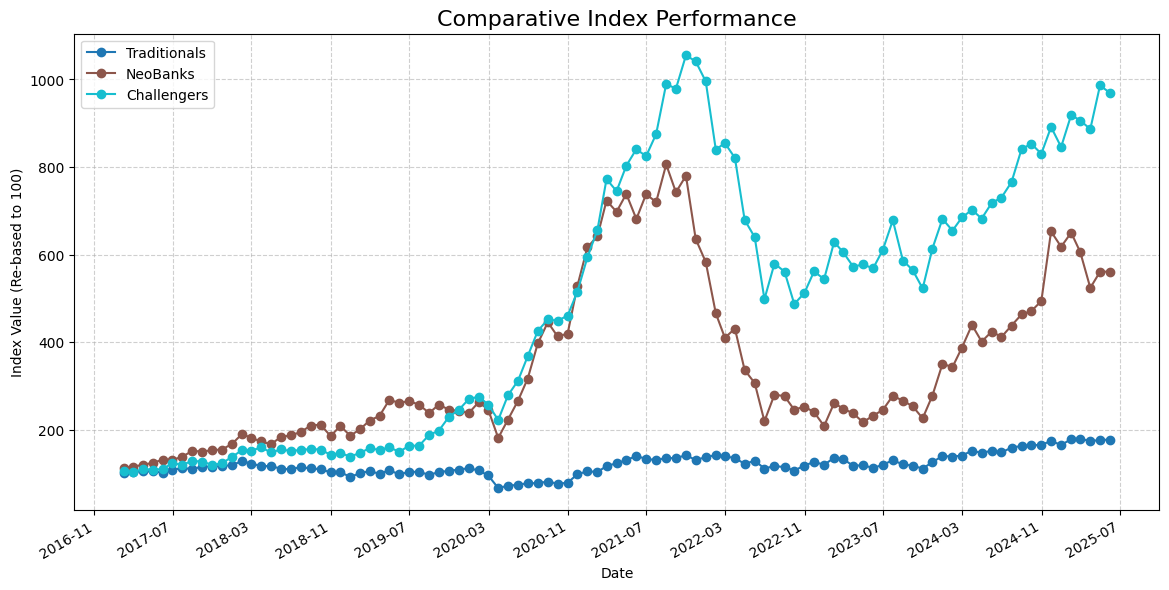


--- Generating individual plots from 2017-01-02 to 2025-05-01 ---
Standardizing individual plot Y-axis from 20.36 to 1166.29


/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/540654191.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = index_series.resample('M').last().dropna()


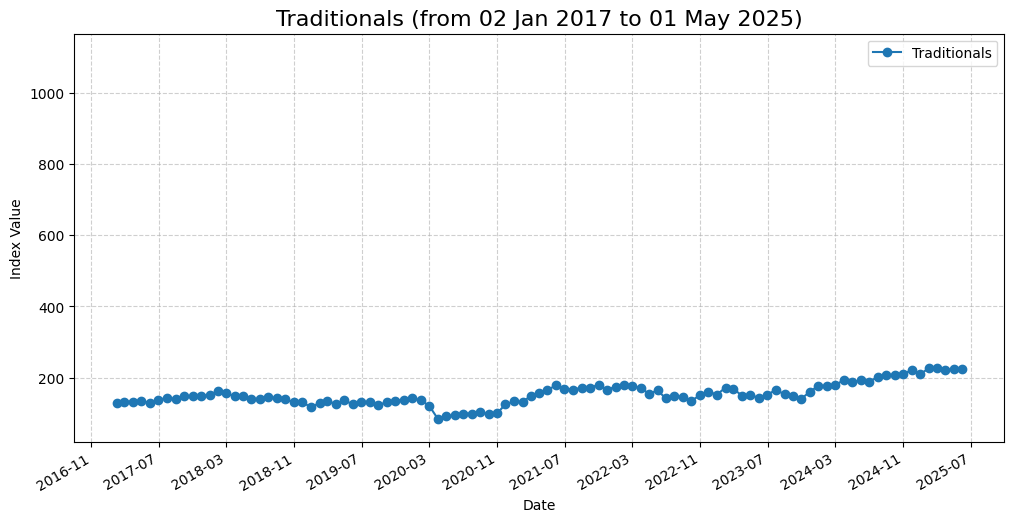

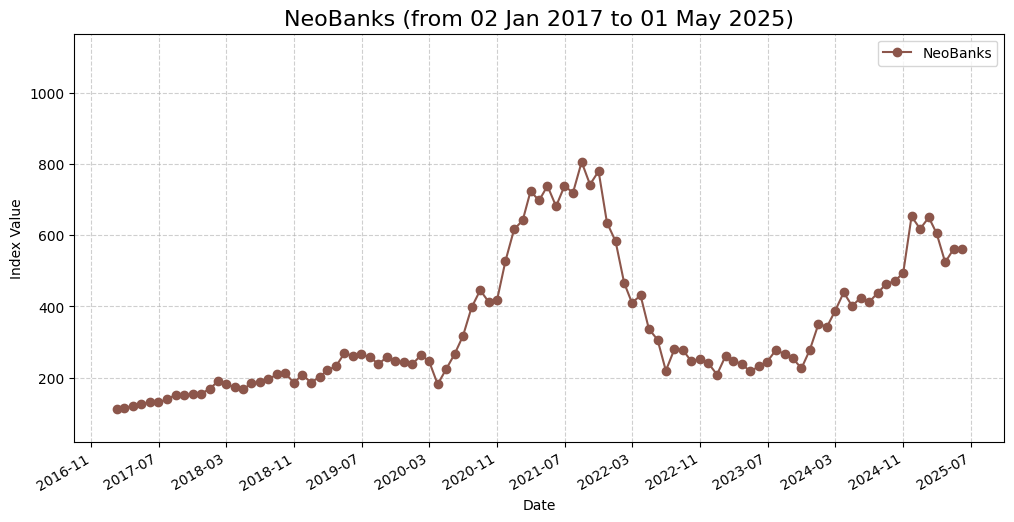

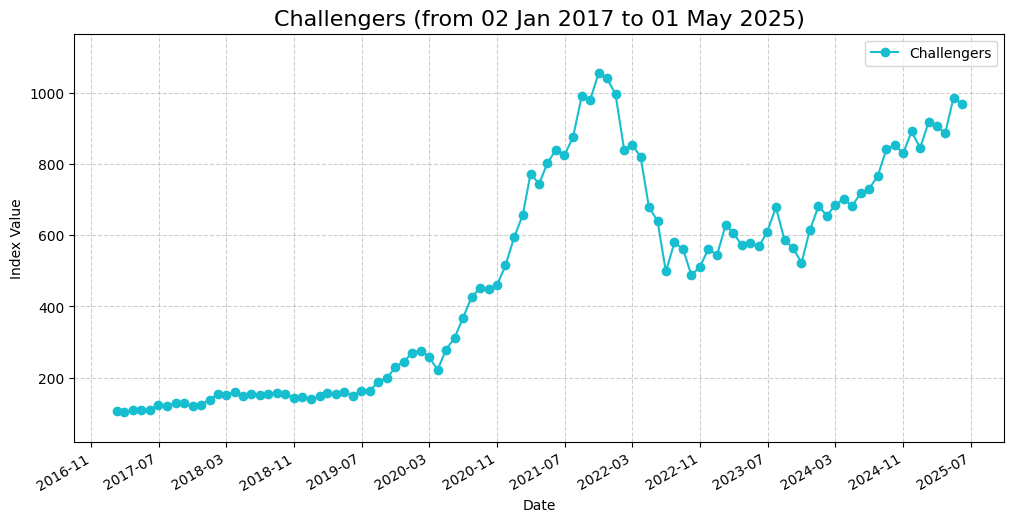

In [8]:
# 1. DEFINE YOUR PARAMETERS AND AUTOMATICALLY DETECT SHEETS
raw_data_file = "All Bank Data.xlsx"
hard_stop_date = pd.to_datetime('2025-05-01')

print(f"--- Step 1: Automatically detecting sheets in '{raw_data_file}' ---")
try:
    # Use pd.ExcelFile to inspect the workbook without loading all data
    xls = pd.ExcelFile(raw_data_file)
    sheets_to_process = xls.sheet_names
    print(f"Success! Found {len(sheets_to_process)} sheets to process:")
    for name in sheets_to_process:
        print(f"  - {name}")
except FileNotFoundError:
    print(f"FATAL ERROR: The file '{raw_data_file}' was not found. Script will now exit.")
    sys.exit() # Exits the script
except Exception as e:
    print(f"FATAL ERROR: An unexpected error occurred while reading the Excel file: {e}")
    sys.exit() # Exits the script

# 2. CALCULATE ALL INDICES FROM THE RAW DATA FILE
calculated_indices = []
for sheet in sheets_to_process:
    index_result = process_sheet_to_index(raw_data_file, sheet)
    if index_result is not None and not index_result.dropna().empty:
        calculated_indices.append(index_result)

# 3. PROCEED ONLY IF INDICES WERE SUCCESSFULLY CALCULATED
if len(calculated_indices) < 2:
    print("\n--- ERROR: Fewer than two indices were successfully calculated. Cannot proceed. ---")
else:
    all_indices_df = pd.concat(calculated_indices, axis=1)
    # --- NEW, CRITICAL LINE TO FIX THE MISSING VALUE ISSUE ---
    # After concatenating, some dates might have NaN if one index had data and another didn't (e.g., holidays).
    # We forward-fill one more time on the final combined DataFrame to clean these up.
    all_indices_df.ffill(inplace=True)

    # --- Part 3.A: Align Data and Generate Plots ---
    first_common_date = all_indices_df.dropna().index[0]
    print(f"\n--- Aligning all indices to first common start date: {first_common_date.date()} ---")
    print(f"--- Truncating all data to end on or before: {hard_stop_date.date()} ---")
    
    final_slice_df = all_indices_df.loc[first_common_date:hard_stop_date].copy()
    comparison_df = (final_slice_df / final_slice_df.iloc[0]) * 100
    
    # --- NEW: Create a consistent color map for all plots ---
    colors = plt.cm.get_cmap('tab10', len(final_slice_df.columns))
    color_map = {col: colors(i) for i, col in enumerate(final_slice_df.columns)}
    print("\n--- Assigned consistent colors to each index for plotting ---")
    
    # --- Generate Comparative Chart with new color map ---
    print("\n--- Aligned and Re-based Index Comparison (First & Last 5 rows) ---")
    print(comparison_df.head())
    print(comparison_df.tail())
    plot_multiple_indices(comparison_df, color_map=color_map, title='Comparative Index Performance')

    # --- Generate Individual Charts with new color map and standardized Y-Axis ---
    print(f"\n--- Generating individual plots from {first_common_date.date()} to {hard_stop_date.date()} ---")
    global_min, global_max = final_slice_df.min().min(), final_slice_df.max().max()
    padding = (global_max - global_min) * 0.05
    y_axis_limits = (global_min - padding, global_max + padding)
    print(f"Standardizing individual plot Y-axis from {y_axis_limits[0]:.2f} to {y_axis_limits[1]:.2f}")

    for index_name in final_slice_df.columns:
        plot_single_index(
            index_series=final_slice_df[index_name], 
            color=color_map[index_name], # Pass the specific color
            title=f"{index_name} (from {first_common_date.strftime('%d %b %Y')} to {hard_stop_date.strftime('%d %b %Y')})",
            y_limits=y_axis_limits
        )

## Saving the equal/aligned indexes to excel.

In [9]:
# 1. DEFINE THE OUTPUT FILENAME
output_file_name = 'calculated_indices_EQUAL.xlsx'

# 2. CHECK IF THE RE-BASED DATA EXISTS
# We use 'comparison_df' which contains the data re-based to 100.
if 'comparison_df' in locals() and not comparison_df.empty:
    print(f"\n--- Saving re-based index data (starts at 100) to: {output_file_name} ---")
    
    try:
        # Use pd.ExcelWriter to save multiple sheets to one file.
        with pd.ExcelWriter(output_file_name, engine='openpyxl') as writer:
            
            # Loop through each column (each index) in the comparison DataFrame.
            for index_name in comparison_df.columns:
                
                # Select the data for the current index.
                single_index_df = comparison_df[[index_name]]
                
                # Write this single-column DataFrame to a new sheet.
                single_index_df.to_excel(writer, sheet_name=index_name, index=True)
                
                print(f"  - Saved '{index_name}' to its own sheet.")

        print(f"\nSuccessfully created '{output_file_name}'. Each index starts at 100.")

    except Exception as e:
        print(f"\nERROR: Could not save the Excel file. Reason: {e}")
        
else:
    print("\n--- No final re-based data available to save. Skipping file export. ---")


--- Saving re-based index data (starts at 100) to: calculated_indices_EQUAL.xlsx ---
  - Saved 'Traditionals' to its own sheet.
  - Saved 'NeoBanks' to its own sheet.
  - Saved 'Challengers' to its own sheet.

Successfully created 'calculated_indices_EQUAL.xlsx'. Each index starts at 100.


# Part 4: Functions for Stationary Testing

## Function 4.A: Running ADF and KPSS on the 3 indexes

In [10]:
def run_stationarity_tests(series, series_name):
    """
    Runs and interprets the Augmented Dickey-Fuller and KPSS tests on a time series.
    This is your original, detailed function.
    """
    print(f"\n--- Stationarity Tests for {series_name} ---")
    series_cleaned = series.dropna()

    # --- Augmented Dickey-Fuller Test ---
    print("\n1. Augmented Dickey-Fuller Test (ADF):")
    adf_result = adfuller(series_cleaned)
    p_value_adf = adf_result[1]
    print(f"   ADF Statistic: {adf_result[0]:.4f}")
    print(f"   p-value: {p_value_adf:.4f}")
    print("   Critical Values:")
    for key, value in adf_result[4].items():
        print(f'      {key}: {value:.4f}')
    if p_value_adf <= 0.05:
        print("\n   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).")
        print("   Reject the null hypothesis. The series is likely stationary.")
    else:
        print("\n   Conclusion: Weak evidence against the null hypothesis (p > 0.05).")
        print("   Fail to reject the null hypothesis. The series is likely non-stationary.")

    # --- KPSS Test ---
    print("\n2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    kpss_result = kpss(series_cleaned, regression='ct')
    p_value_kpss = kpss_result[1]
    print(f"   KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"   p-value: {p_value_kpss:.4f}")
    print("   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f'      {key}: {value:.4f}')
    if p_value_kpss <= 0.05:
        print("\n   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).")
        print("   Reject the null hypothesis. The series is likely non-stationary.")
    else:
        print("\n   Conclusion: Weak evidence against the null hypothesis (p > 0.05).")
        print("   Fail to reject the null hypothesis. The series is likely trend-stationary.")

### Function 5.B: Testing for stationarity on Index RETURNS (YOUR ORIGINAL FUNCTION)
def run_stationarity_tests_on_transformed_data(series, series_name):
    """
    Runs ADF and KPSS tests specifically for transformed (differenced) data.
    This is your original, detailed function for returns.
    """
    print(f"\n--- Stationarity Tests for: {series_name} ---")
    
    # --- Augmented Dickey-Fuller Test ---
    print("\n1. Augmented Dickey-Fuller Test (ADF):")
    adf_result = adfuller(series)
    p_value_adf = adf_result[1]
    print(f"   p-value: {p_value_adf:.4f}")
    if p_value_adf <= 0.05:
        print("   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.")
    else:
        print("   Conclusion: FAIL to reject the null hypothesis. The series is likely NON-STATIONARY.")

    # --- KPSS Test ---
    print("\n2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):")
    kpss_result = kpss(series, regression='c')
    p_value_kpss = kpss_result[1]
    print(f"   p-value: {p_value_kpss:.4f}")
    if p_value_kpss <= 0.05:
        print("   Conclusion: REJECT the null hypothesis. The series is likely NON-STATIONARY.")
    else:
        print("   Conclusion: FAIL to reject the null hypothesis. The series is likely STATIONARY.")


# Part 5: Main Script for ADF and KPSS tests

In [11]:
# This automated loop will run the tests on every index calculated in Part 3.
if 'final_slice_df' in locals() and not final_slice_df.empty:
    
    # Loop through each column (each index) in our final DataFrame.
    for index_name in final_slice_df.columns:
        print(f"\n\n{'='*70}")
        print(f"PERFORMING STATIONARITY ANALYSIS FOR: {index_name}")
        print(f"{'='*70}")

        # --- Step 1: Test the original series (Levels) ---
        series_levels = final_slice_df[index_name]
        run_stationarity_tests(series_levels, f"{index_name} (Levels)")

        # --- Step 2: Test the transformed series (Returns) ---
        print("\n--- Applying First-Difference Transformation ---")
        series_returns = series_levels.diff().dropna()
        run_stationarity_tests_on_transformed_data(series_returns, f"{index_name} (Returns)")
else:
    print("\n--- Could not find calculated index data ('final_slice_df'). Skipping Stationarity Tests. ---")



PERFORMING STATIONARITY ANALYSIS FOR: Traditionals

--- Stationarity Tests for Traditionals (Levels) ---

1. Augmented Dickey-Fuller Test (ADF):
   ADF Statistic: -1.1346
   p-value: 0.7011
   Critical Values:
      1%: -3.4334
      5%: -2.8629
      10%: -2.5675

   Conclusion: Weak evidence against the null hypothesis (p > 0.05).
   Fail to reject the null hypothesis. The series is likely non-stationary.

2. Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS):
   KPSS Statistic: 0.7314
   p-value: 0.0100
   Critical Values:
      10%: 0.1190
      5%: 0.1460
      2.5%: 0.1760
      1%: 0.2160

   Conclusion: Strong evidence against the null hypothesis (p <= 0.05).
   Reject the null hypothesis. The series is likely non-stationary.

--- Applying First-Difference Transformation ---

--- Stationarity Tests for: Traditionals (Returns) ---

1. Augmented Dickey-Fuller Test (ADF):
   p-value: 0.0000
   Conclusion: REJECT the null hypothesis. The series is likely STATIONARY.

2. Kwiatkowski-Ph

/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/2362815342.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')
/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/2362815342.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c')
/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/2362815342.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series_cleaned, regression='ct')
/var/folders/0f/_zt843k12vs010rnwnmcwf9c0000gn/T/ipykernel_76831/2362815342.py:61: InterpolationW

# Part 6: Descriptive Statistics

### This section calculates and displays a detailed statistical summary for each of the final, time-aligned indices (the 'levels' data from Part 3).

In [12]:
if 'final_slice_df' in locals() and not final_slice_df.empty:
    print(f"\n\n{'='*70}")
    print("CALCULATING DESCRIPTIVE STATISTICS")
    print(f"{'='*70}")
    
    try:
        # 1. The .describe() method calculates the most common stats
        summary_df = final_slice_df.describe()

        # 2. Calculate Skewness and Kurtosis separately
        skewness = final_slice_df.skew()
        kurtosis = final_slice_df.kurtosis()

        # 3. Add them as new rows to our summary DataFrame
        summary_df.loc['Skewness'] = skewness
        summary_df.loc['Kurtosis'] = kurtosis

        # 4. Display the final, formatted table
        print("\n--- Statistical Summary of Aligned Index Levels ---")
        
        # Optional: Set a display format for cleaner output
        pd.options.display.float_format = '{:,.4f}'.format
        
        print(summary_df)

    except Exception as e:
        print(f"\nAn error occurred while calculating statistics: {e}")

else:
    print("\n--- Could not find calculated index data ('final_slice_df'). Skipping Descriptive Statistics. ---")



CALCULATING DESCRIPTIVE STATISTICS

--- Statistical Summary of Aligned Index Levels ---
          Traditionals   NeoBanks  Challengers
count       2,159.0000 2,159.0000   2,159.0000
mean          152.6635   341.7846     480.5196
std            30.0546   187.7011     295.9075
min            72.4485   100.0000      96.1423
25%           133.7288   205.4675     156.2087
50%           148.2370   260.4697     532.4504
75%           170.7494   439.5708     723.4721
max           233.3720   846.1734   1,114.2027
Skewness        0.3512     0.9855       0.1573
Kurtosis        0.2303    -0.1455      -1.3519


# Part 7: Connectedness Analysis

In [13]:


print(f"\n\n{'='*70}")
print("PREPARING DATA FOR CONNECTEDNESS ANALYSIS")
print(f"{'='*70}")

if 'final_slice_df' in locals() and not final_slice_df.empty:
    # 1. Calculate daily percentage returns.
    # The .pct_change() method is perfect for this.
    returns_df = final_slice_df.pct_change()

    # 2. Drop the first row, which will be NaN after calculating returns.
    returns_df.dropna(inplace=True)

    # 3. Multiply by 100 to express returns as percentages (optional but common practice).
    returns_df = returns_df * 100

    print("\n--- Daily Returns Data Prepared for R (First 5 rows) ---")
    print(returns_df.head())

else:
    print("\n--- Could not find 'final_slice_df'. Skipping Connectedness Analysis. ---")
    # We will create an empty dataframe so the next cells don't error out
    returns_df = pd.DataFrame()



PREPARING DATA FOR CONNECTEDNESS ANALYSIS

--- Daily Returns Data Prepared for R (First 5 rows) ---
            Traditionals  NeoBanks  Challengers
Date                                           
2017-01-03        1.0247    3.1254       0.3080
2017-01-04        1.2603    2.7531       0.3522
2017-01-05       -0.0865    1.0332       0.7906
2017-01-06        0.1468    0.4642      -0.7026
2017-01-09       -0.5631    0.0415      -0.8442


## Step 2: Static Connectedness Analysis
This analysis gives us a single table that represents the average spillover effects over your entire sample period. It's a great starting point.

## OPTIMAL LAG ORDER SELECTION (AIC/SIC) 

In [14]:
%%R -i returns_df

# This cell performs the formal lag order selection.
# It uses the 'vars' package, which is a standard for VAR models in R.

if (nrow(returns_df) > 0) {
    # Load the necessary R libraries
    library(vars)
    library(zoo)

    # Convert the pandas DataFrame to a zoo object, which is compatible.
    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    print("--- Calculating Optimal Lag Order using Information Criteria ---")
    
    # The VARselect function tests lags from 1 up to a specified maximum
    # and reports the score for each criterion.
    # We will test up to a maximum of 8 lags, which is more than enough for daily data.
    lag_selection <- VARselect(data_zoo, lag.max = 8, type = "const")

    print(lag_selection$selection)
    print("--- Detailed Criteria Scores (lower is better) ---")
    print(lag_selection$criteria)

} else {
    print("Input data is empty. Skipping lag selection.")
}

[1] "--- Calculating Optimal Lag Order using Information Criteria ---"
AIC(n)  HQ(n)  SC(n) FPE(n) 
     7      1      1      7 
[1] "--- Detailed Criteria Scores (lower is better) ---"
              1        2        3        4        5        6        7        8
AIC(n) 2.178064 2.169968 2.167129 2.169858 2.166587 2.161920 2.145753 2.151677
HQ(n)  2.189648 2.190240 2.196089 2.207507 2.212923 2.216944 2.209466 2.224078
SC(n)  2.209729 2.225381 2.246291 2.272768 2.293245 2.312326 2.319908 2.349581
FPE(n) 8.829200 8.758002 8.733180 8.757049 8.728451 8.687812 8.548497 8.599298


Loading required package: MASS
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: urca
Loading required package: lmtest

Attaching package: ‘vars’

The following object is masked from ‘package:ConnectednessApproach’:

    VAR



[1] "--- Static Connectedness Table (Average over entire period) ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "58.46"      "19.65"  "21.89"     "41.54"      
NeoBanks     "19.02"      "57.29"  "23.69"     "42.71"      
Challengers  "20.84"      "24.62"  "54.54"     "45.46"      
TO           " 39.86"     " 44.27" " 45.58"    "129.70"     
Inc.Own      " 98.32"     "101.56" "100.12"    "cTCI/TCI"   
NET          "-1.68"      " 1.56"  " 0.12"     "64.85/43.23"
NPT          "0.00"       "2.00"   "1.00"      ""           


Estimating model
Computing connectedness measures
The (generalized) VAR connectedness approach is implemented according to:
 Diebold, F. X., & Yilmaz, K. (2012). Better to give than to receive: Predictive directional measurement of volatility spillovers. International Journal of Forecasting.


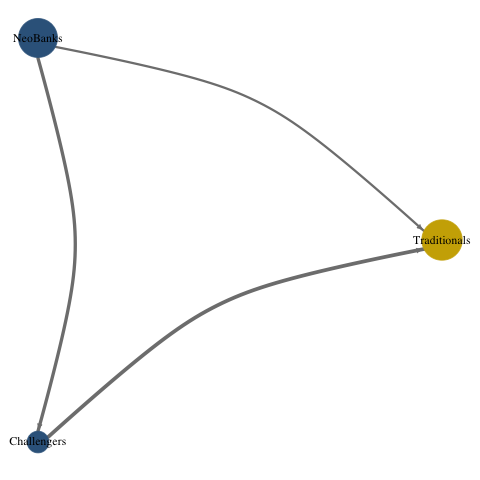

In [15]:
%%R -i returns_df

# Check if the input dataframe is not empty
if (nrow(returns_df) > 0) {
    # Load the necessary R libraries
    library(ConnectednessApproach)
    library(zoo)

    # Convert the pandas DataFrame to a zoo object, which the library requires
    # The date index is automatically recognized.
    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Static Connectedness Analysis ---
    # This calculates the average connectedness over the entire period.
    # nlag = 2: We use 2 lags in our model (a common starting point).
    # nfore = 10: We forecast 10 days ahead to see how shocks propagate.
    # window.size = NULL: This specifically tells the function to do a static (non-rolling) analysis.
    dca_static <- ConnectednessApproach(data_zoo,
                                      nlag = 1,
                                      nfore = 10,
                                      window.size = NULL,
                                      model = "VAR") # Using a standard Vector Autoregression model

    # Print the resulting connectedness table
    print("--- Static Connectedness Table (Average over entire period) ---")
    print(dca_static$TABLE)
    PlotNetwork(dca_static, method ="NPDC")
    #PlotNetwork(dca_static, method ="PCI")

} else {
    print("Input data is empty. Skipping static analysis.")
}

## Step 3: Dynamic Connectedness Analysis
This is the main event. We'll use a rolling window to see how these spillovers evolve over time. This will allow us to create the insightful plots.


"To capture the time-varying nature of the spillover effects, this study employs the rolling-window VAR methodology as proposed by Diebold and Yilmaz (2012). A window size of 200 days was chosen to balance parameter stability with sensitivity to changes in market regimes. This approach provides a robust and well-established framework for analyzing dynamic connectedness."

In [16]:
%%R -i returns_df -o dca_dynamic_results

# Check if the input dataframe is not empty
if (nrow(returns_df) > 0) {
    library(ConnectednessApproach)
    library(zoo)

    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Dynamic (Rolling Window) Analysis ---
    # The only change is setting window.size.
    # window.size = 200: We use a 200-day rolling window, which is a common standard.
    # This means each calculation is based on the previous ~9 months of data.
    dca_dynamic_results <- ConnectednessApproach(data_zoo,
                                       nlag = 1,
                                       nfore = 10,
                                       window.size = 200, # This activates the dynamic analysis
                                       model = "VAR")

    # The object 'dca_dynamic' now contains the full history of connectedness over time.
    # We send it back to Python with '-o dca_dynamic_results' just in case,
    # but we will do the plotting in R.

    # Print the AVERAGE table from the dynamic results
    print("--- Average Dynamic Connectedness Table (Average of all rolling windows) ---")
    print(dca_dynamic_results$TABLE)
} else {
    print("Input data is empty. Skipping dynamic analysis.")
}

[1] "--- Average Dynamic Connectedness Table (Average of all rolling windows) ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "62.46"      "17.65"  "19.88"     "37.54"      
NeoBanks     "17.68"      "61.44"  "20.87"     "38.56"      
Challengers  "19.88"      "21.23"  "58.88"     "41.12"      
TO           " 37.57"     " 38.89" " 40.76"    "117.21"     
Inc.Own      "100.03"     "100.33" " 99.64"    "cTCI/TCI"   
NET          " 0.03"      " 0.33"  "-0.36"     "58.61/39.07"
NPT          "1.00"       "1.00"   "1.00"      ""           


Estimating model
Computing connectedness measures
The (generalized) VAR connectedness approach is implemented according to:
 Diebold, F. X., & Yilmaz, K. (2012). Better to give than to receive: Predictive directional measurement of volatility spillovers. International Journal of Forecasting.


## Step 4: Visualizing the Dynamic Results
Now we use the dca_dynamic object we just created in the R environment to generate the plots.

[1] "Plotting Total Connectedness Index (TCI)..."
[1] "Plotting Net Total Directional Connectedness (NET)..."
[1] "Plotting Net Pairwise Directional Connectedness (NPDC)..."


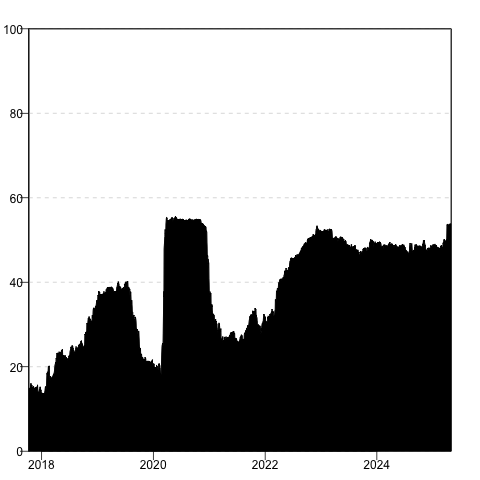

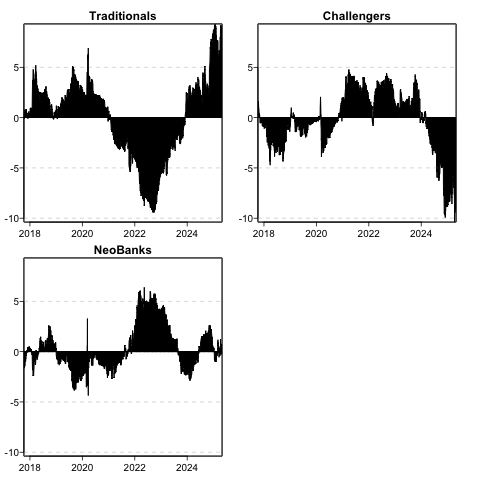

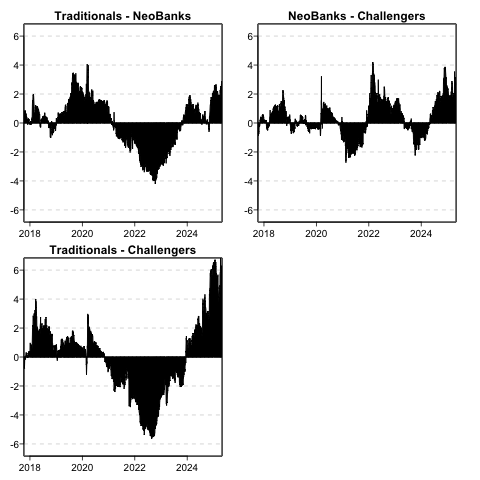

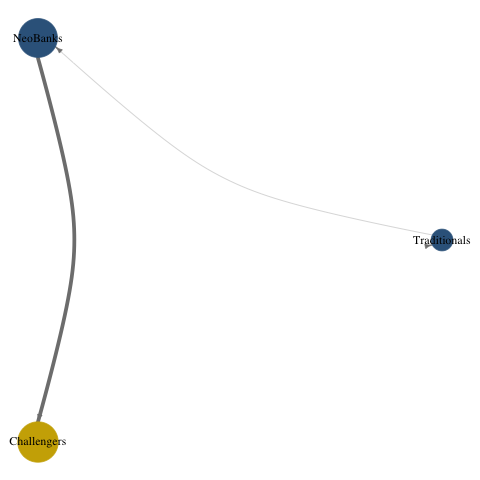

In [17]:
%%R

# This cell uses the 'dca_dynamic' object created in the cell above.
# We don't need to pass data in again.

if (exists("dca_dynamic_results")) {
    # --- Plot 1: Total Connectedness Index (TCI) ---
    # Shows the overall level of risk in the system over time.
    # Spikes indicate periods of high market stress and contagion.
    print("Plotting Total Connectedness Index (TCI)...")
    PlotTCI(dca_dynamic_results)

    # --- Plot 2: Net Total Directional Connectedness (NET) ---
    # THE MOST IMPORTANT PLOT. Shows who the net transmitters/receivers are over time.
    # When a line is > 0, that index is a net source of risk to the system.
    # When a line is < 0, that index is a net recipient of risk.
    print("Plotting Net Total Directional Connectedness (NET)...")
    PlotNET(dca_dynamic_results)

    # --- Plot 3: Net Pairwise Directional Connectedness (NPDC) ---
    # Shows the net relationship between each pair of indices.
    # e.g., for the "Neo-Trad" plot: when > 0, Neo is transmitting to Trad.
    # When < 0, Trad is transmitting to Neo.
    print("Plotting Net Pairwise Directional Connectedness (NPDC)...")
    PlotNPDC(dca_dynamic_results)
    
    PlotNetwork(dca_dynamic_results, method ="NPDC")

} else {
    print("Dynamic results object 'dca_dynamic_results' not found. Skipping plots.")
}

1. TCI (Total Connectedness Index) - "How Loud is the Room?"
What it is: The TCI measures the overall level of influence in the entire system. It's a single number that represents the total amount of spillovers happening among all participants.
Key Question: "How interconnected is the system as a whole right now?"
Analogy: The TCI is the total volume of the conversation. A low TCI is a quiet library where everyone is working independently. A high TCI is a loud, energetic party where everyone is reacting to everyone else.
What the Plot Shows: A single line moving over time. A spike in the TCI plot means the entire system became more interconnected and riskier (e.g., during a financial crisis). It's the "fever chart" for systemic risk.
2. NET (Net Total Directional Connectedness) - "Who is the Main Influencer?"
What it is: The NET spillover for a single index tells you if it is, on balance, an exporter or importer of shocks to the entire system. It's calculated as (Total Influence FROM this index) - (Total Influence TO this index).
Key Question: "Is this index primarily a source of risk (a transmitter) or a recipient of risk (a receiver)?"
Analogy: The NET value identifies the main talkers and the main listeners.
A person who talks far more than they listen has a positive NET value (a Net Transmitter).
A person who listens more than they talk has a negative NET value (a Net Receiver).
What the Plot Shows: One line for each index. When an index's line is above zero, it's a net source of risk to the system. When it's below zero, it's absorbing risk from the system.
3. NPDC (Net Pairwise Directional Connectedness) - "In This Specific Chat, Who is Dominating?"
What it is: The NPDC zooms in on the relationship between just two specific indices. It measures the net influence in a single, one-on-one pairing. It's calculated as (Influence from A to B) - (Influence from B to A).
Key Question: "Between these two specific indices, who influences the other one more?"
Analogy: The NPDC looks at a private chat between two people. If Alice is talking to Bob more than Bob is talking to Alice, the NPDC from Alice's perspective is positive. She is dominating that specific conversation.
What the Plot Shows: A separate plot for each pair of indices (e.g., a plot for "NeoBanks vs. Traditionals"). When the line is above zero, the first-named index is dominating the second. When it's below zero, the second is dominating the first.


## Step 5: TVP-VAR model

[1] "--- TVP-VAR Average Connectedness Table ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "61.61"      "18.30"  "20.10"     "38.39"      
NeoBanks     "18.05"      "61.28"  "20.68"     "38.72"      
Challengers  "19.88"      "21.40"  "58.72"     "41.28"      
TO           " 37.93"     " 39.70" " 40.77"    "118.40"     
Inc.Own      " 99.54"     "100.97" " 99.49"    "cTCI/TCI"   
NET          "-0.46"      " 0.97"  "-0.51"     "59.20/39.47"
NPT          "0.00"       "2.00"   "1.00"      ""           
[1] "--- Plotting TVP-VAR Dynamic Results ---"


Estimating model
Computing connectedness measures
The TVP-VAR connectedness approach is implemented according to:
 Antonakakis, N., Chatziantoniou, I., & Gabauer, D. (2020). Refined measures of dynamic connectedness based on time-varying parameter vector autoregressions. Journal of Risk and Financial Management.


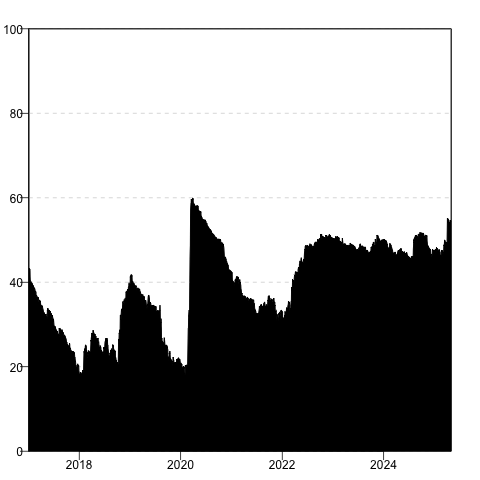

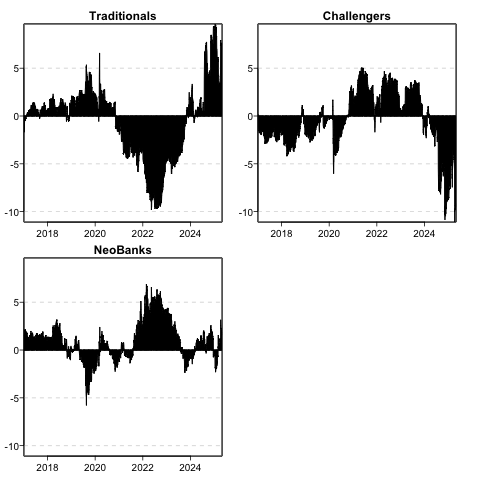

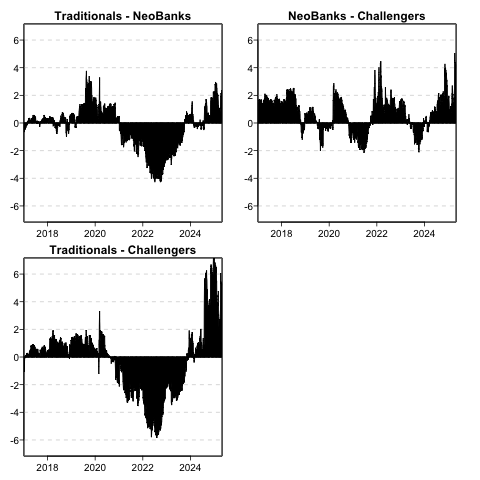

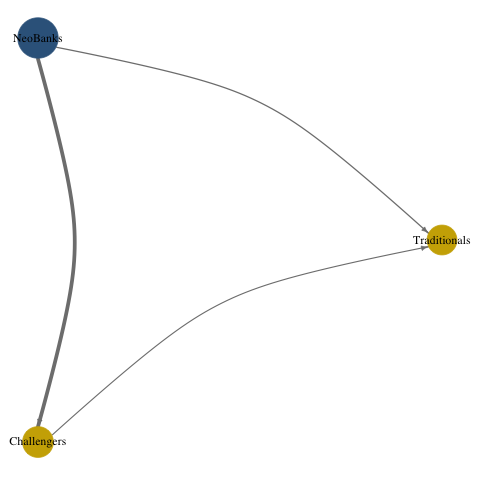

In [18]:
%%R -o dca_tvp_var_results

# This cell runs the more advanced TVP-VAR model.
# It uses the same 'returns_df' created in the Python cell.

if (nrow(returns_df) > 0) {
    library(ConnectednessApproach)
    library(zoo)

    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Dynamic Connectedness Analysis using TVP-VAR ---
    # The key changes are: model="TVP-VAR" and the VAR_config list.
    # The kappa parameters are "forgetting factors" that control how fast the parameters can change.
    # 0.99 is a very standard value.
    dca_tvp_var_results <- ConnectednessApproach(data_zoo,
                                       nlag = 1,
                                       nfore = 10,
                                       model = "TVP-VAR",
                                       VAR_config = list(TVPVAR = list(kappa1 = 0.99, kappa2 = 0.99, prior = "BayesPrior"))
                                       )

    # Print the resulting connectedness table
    print("--- TVP-VAR Average Connectedness Table ---")
    print(dca_tvp_var_results$TABLE)

    # --- Generate the plots for the TVP-VAR results ---
    print("--- Plotting TVP-VAR Dynamic Results ---")
    PlotTCI(dca_tvp_var_results)
    PlotNET(dca_tvp_var_results)
    PlotNPDC(dca_tvp_var_results)
    PlotNetwork(dca_tvp_var_results, method ="NPDC")


} else {
    print("Input data is empty. Skipping TVP-VAR analysis.")
}

To ensure the robustness of our findings and to investigate the spillover dynamics with greater flexibility, we supplement our rolling-window analysis with a Time-Varying Parameter Vector Autoregression (TVP-VAR) model. This state-of-the-art technique relaxes the assumption of parameter stability inherent in fixed-window estimations, allowing the system's interconnectedness to evolve at every time step. The TVP-VAR is especially adept at identifying rapid shifts in market regimes that might be smoothed over by a rolling-window analysis. By comparing the results from both methodologies, we can draw more resilient conclusions about the nature of return spillovers among the banking sectors.

## Step 6: Running VAR model with window.size 20

In [19]:
%%R -i returns_df -o dca_dynamic_results20

# Check if the input dataframe is not empty
if (nrow(returns_df) > 0) {
    library(ConnectednessApproach)
    library(zoo)

    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Run the Dynamic (Rolling Window) Analysis ---
    # The only change is setting window.size.
    # window.size = 200: We use a 200-day rolling window, which is a common standard.
    # This means each calculation is based on the previous ~9 months of data.
    dca_dynamic_results20 <- ConnectednessApproach(data_zoo,
                                       nlag = 1,
                                       nfore = 10,
                                       window.size = 20, # This activates the dynamic analysis
                                       model = "VAR")

    # The object 'dca_dynamic' now contains the full history of connectedness over time.
    # We send it back to Python with '-o dca_dynamic_results' just in case,
    # but we will do the plotting in R.

    # Print the AVERAGE table from the dynamic results
    print("--- Average Dynamic Connectedness Table (Average of all rolling windows) ---")
    print(dca_dynamic_results20$TABLE)
} else {
    print("Input data is empty. Skipping dynamic analysis.")
}




[1] "--- Average Dynamic Connectedness Table (Average of all rolling windows) ---"
             Traditionals NeoBanks Challengers FROM         
Traditionals "59.17"      "19.83"  "21.00"     "40.83"      
NeoBanks     "20.00"      "59.18"  "20.82"     "40.82"      
Challengers  "21.49"      "21.16"  "57.35"     "42.65"      
TO           " 41.49"     " 40.99" " 41.82"    "124.30"     
Inc.Own      "100.66"     "100.18" " 99.17"    "cTCI/TCI"   
NET          " 0.66"      " 0.18"  "-0.83"     "62.15/41.43"
NPT          "2.00"       "1.00"   "0.00"      ""           


Estimating model
Computing connectedness measures
The (generalized) VAR connectedness approach is implemented according to:
 Diebold, F. X., & Yilmaz, K. (2012). Better to give than to receive: Predictive directional measurement of volatility spillovers. International Journal of Forecasting.


[1] "Plotting Total Connectedness Index (TCI)..."
[1] "Plotting Net Total Directional Connectedness (NET)..."
[1] "Plotting Net Pairwise Directional Connectedness (NPDC)..."


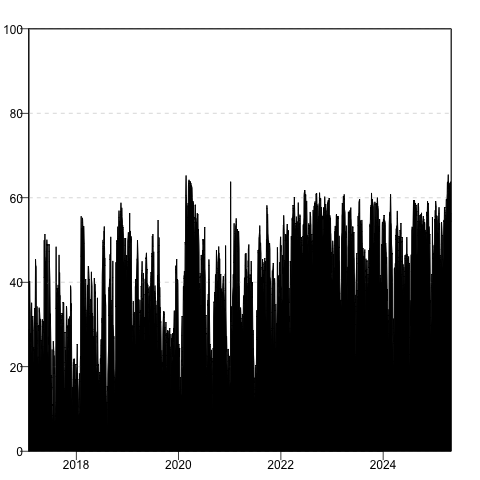

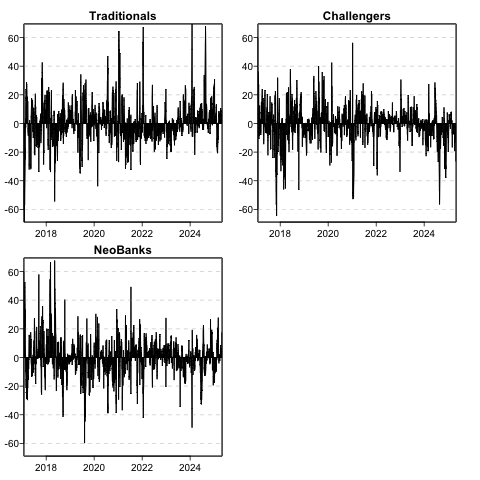

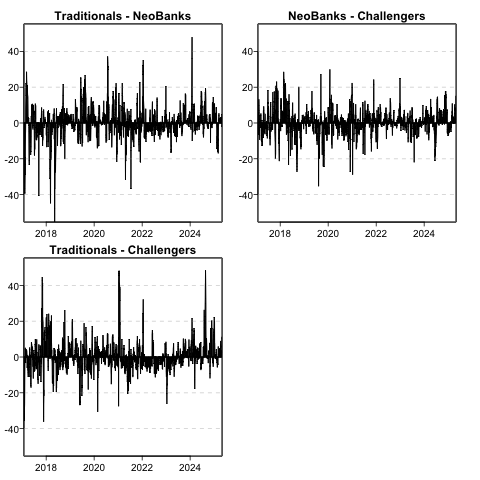

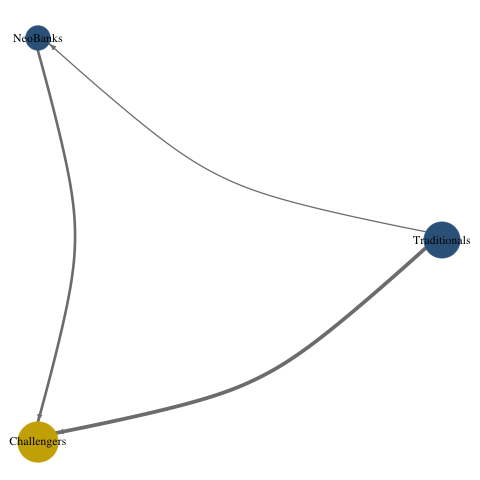

In [20]:
%%R

# This cell uses the 'dca_dynamic' object created in the cell above.
# We don't need to pass data in again.

if (exists("dca_dynamic_results20")) {
    # --- Plot 1: Total Connectedness Index (TCI) ---
    # Shows the overall level of risk in the system over time.
    # Spikes indicate periods of high market stress and contagion.
    print("Plotting Total Connectedness Index (TCI)...")
    PlotTCI(dca_dynamic_results20)

    # --- Plot 2: Net Total Directional Connectedness (NET) ---
    # THE MOST IMPORTANT PLOT. Shows who the net transmitters/receivers are over time.
    # When a line is > 0, that index is a net source of risk to the system.
    # When a line is < 0, that index is a net recipient of risk.
    print("Plotting Net Total Directional Connectedness (NET)...")
    PlotNET(dca_dynamic_results20)

    # --- Plot 3: Net Pairwise Directional Connectedness (NPDC) ---
    # Shows the net relationship between each pair of indices.
    # e.g., for the "Neo-Trad" plot: when > 0, Neo is transmitting to Trad.
    # When < 0, Trad is transmitting to Neo.
    print("Plotting Net Pairwise Directional Connectedness (NPDC)...")
    PlotNPDC(dca_dynamic_results20)
    PlotNetwork(dca_dynamic_results20, method ="NPDC")
    
    
} else {
    print("Dynamic results object 'dca_dynamic_results20' not found. Skipping plots.")
}

# Part 9: Comprehensive Univariate GARCH Model Selection

In [ ]:
%%R -i returns_df

# This cell fits a comprehensive suite of GARCH(1,1) models to each index
# and uses information criteria (AIC/BIC) to determine the best specification.

if (nrow(returns_df) > 0) {
    # Load the necessary R libraries
    library(rugarch)
    library(zoo)

    # Convert the pandas DataFrame to a zoo object
    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Step 1: Define the "Contestants" (Similar to the reference code) ---
    # We will test a wide array of common GARCH model types.
    # This list mirrors the options in the GARCHselection function.
    model_types <- c("sGARCH", "gjrGARCH", "eGARCH", "iGARCH", "csGARCH")
    
    # We will also test a comprehensive set of distributions for the errors.
    distributions <- c("norm", "std", "sstd", "ged", "sged")

    # This will hold our final results
    final_results_table <- data.frame()
    
    # This list will store the "winning" specification for each index,
    # just like the 'spec' object in the reference code.
    best_spec_list <- list()
    
    # Get the names of our indices
    index_names <- colnames(data_zoo)

    # --- Step 2: Run the "Competition" for each index ---
    for (i in 1:ncol(data_zoo)) {
        
        current_index_name <- index_names[i]
        print(paste0("--- Fitting GARCH Models for: ", current_index_name, " ---"))
        
        # This will store the results for the current index
        index_results <- data.frame()

        # This inner loop fits every combination of model and distribution
        for (model in model_types) {
            for (dist in distributions) {
                
                # Define the GARCH(1,1) specification ("the recipe")
                spec <- ugarchspec(
                    variance.model = list(model = model, garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(0, 0)),
                    distribution.model = dist
                )
                
                # Fit the model to the data
                fit <- tryCatch({
                    ugarchfit(spec = spec, data = data_zoo[, i], solver = 'hybrid')
                }, error = function(e) NULL)
                
                # If the model was fitted successfully, get its scores
                if (!is.null(fit)) {
                    info_criteria <- infocriteria(fit)
                    result_row <- data.frame(
                        Index = current_index_name,
                        Model = model,
                        Distribution = dist,
                        AIC = info_criteria[1],
                        BIC = info_criteria[2]
                    )
                    index_results <- rbind(index_results, result_row)
                }
            }
        }
        
        # --- Step 3: Determine the "Winner" and Store the Winning Recipe ---
        if (nrow(index_results) > 0) {
            # Find the row with the lowest BIC score
            best_model_row <- index_results[which.min(index_results$BIC), ]
            
            print(paste0("Best Model for ", current_index_name, " (BIC): ", 
                         best_model_row$Model, " with ", best_model_row$Distribution, " distribution."))
            
            # Create the winning specification and store it in our list
            # This is the 'spec' object needed for the DCC-GARCH model later.
            best_spec <- ugarchspec(
                variance.model = list(model = as.character(best_model_row$Model), garchOrder = c(1, 1)),
                mean.model = list(armaOrder = c(0, 0)),
                distribution.model = as.character(best_model_row$Distribution)
            )
            best_spec_list[[current_index_name]] <- best_spec
            
            # Add the full results for this index to our final summary table
            final_results_table <- rbind(final_results_table, index_results)
        } else {
            print(paste0("WARNING: No GARCH models could be fitted for ", current_index_name))
        }
    }

    # --- Step 4: Display the final summary table ---
    print(paste0("\n", paste(rep("-", 70), collapse="")))
    print("Final GARCH Model Selection Summary (Lower Score is Better)")
    print(paste(rep("-", 70), collapse=""))
    # Use kable for a cleaner table format if available, otherwise just print
    if ("knitr" %in% rownames(installed.packages())) {
        print(knitr::kable(final_results_table))
    } else {
        print(final_results_table)
    }

    # You now have an object called 'best_spec_list' in your R session.
    # This list contains the best GARCH model for each of your indices,
    # ready to be used as the input for a DCC-GARCH model, just like in the example.

} else {
    print("Input data is empty. Skipping GARCH model selection.")
}

[1] "--- Fitting GARCH Models for: Traditionals ---"
[1] "Best Model for Traditionals (BIC): eGARCH with sstd distribution."
[1] "--- Fitting GARCH Models for: NeoBanks ---"
[1] "Best Model for NeoBanks (BIC): gjrGARCH with std distribution."
[1] "--- Fitting GARCH Models for: Challengers ---"
[1] "Best Model for Challengers (BIC): gjrGARCH with std distribution."
[1] "\n----------------------------------------------------------------------"
[1] "Final GARCH Model Selection Summary (Lower Score is Better)"
[1] "----------------------------------------------------------------------"


|Index        |Model    |Distribution |      AIC|      BIC|
|:------------|:--------|:------------|--------:|--------:|
|Traditionals |sGARCH   |norm         | 3.159539| 3.170062|
|Traditionals |sGARCH   |std          | 3.098137| 3.111291|
|Traditionals |sGARCH   |sstd         | 3.094229| 3.110013|
|Traditionals |sGARCH   |ged          | 3.100600| 3.113753|
|Traditionals |sGARCH   |sged         | 3.098456|

# Part 10: Diagnostic Testing of Selected GARCH Models

This section performs quality control on the "winning" GARCH model for each index to ensure they are statistically sound before proceeding.

In [32]:
%%R

# This cell performs diagnostic tests on the "winning" GARCH model for each index
# to ensure they are a good fit for the data. This is a critical quality control step.

if (exists("best_spec_list")) {
    
    # --- Load Required Libraries ---
    # We need 'rugarch' for the models and 'FinTS' for the ArchTest diagnostic.
    library(rugarch)
    library(FinTS)

    # This will hold the results of our diagnostic tests
    diagnostic_table <- NULL
    
    index_names <- names(best_spec_list)

    print("--- Performing Diagnostic Tests on Winning GARCH Models ---")
    
    # Loop through each of our "winning" model specifications
    for (i in 1:length(best_spec_list)) {
        
        current_index_name <- index_names[i]
        current_spec <- best_spec_list[[i]]
        
        print(paste0("Testing model for: ", current_index_name))
        
        # 1. Fit the final, winning model to the data
        final_fit <- ugarchfit(spec = current_spec, data = data_zoo[, current_index_name], solver = 'hybrid')
        
        # 2. Run the ARCH-LM test on the standardized residuals.
        # This test checks for any remaining "ARCH effects" (volatility clustering).
        # We want a high p-value here, indicating our model captured the effects.
        # Note: We use the standardized residuals from the fit object.
        arch_test <- ArchTest(residuals(final_fit, standardize = TRUE), lags = 20)
        
        # 3. Store the key results in a clean table
        result_row <- data.frame(
            Index = current_index_name,
            Model = current_spec@model$modeldesc$vmodel,
            Distribution = current_spec@model$modeldesc$distribution,
            ARCH_LM_Test_p_value = arch_test$p.value
        )
        diagnostic_table <- rbind(diagnostic_table, result_row)
    }
    
    # 4. Display the final diagnostic summary
    print(paste0("\n", paste(rep("-", 70), collapse="")))
    print("GARCH Model Diagnostic Summary")
    print(paste(rep("-", 70), collapse=""))
    print("A high p-value (> 0.05) is desired, indicating no remaining volatility clustering.")
    
    if ("knitr" %in% rownames(installed.packages())) {
        print(knitr::kable(diagnostic_table))
    } else {
        print(diagnostic_table)
    }

} else {
    print("Object 'best_spec_list' not found. Please run the GARCH selection cell first.")
}

[1] "--- Performing Diagnostic Tests on Winning GARCH Models ---"
[1] "Testing model for: Traditionals"
[1] "Testing model for: NeoBanks"
[1] "Testing model for: Challengers"
[1] "\n----------------------------------------------------------------------"
[1] "GARCH Model Diagnostic Summary"
[1] "----------------------------------------------------------------------"
[1] "A high p-value (> 0.05) is desired, indicating no remaining volatility clustering."


|             |Index        |Model    |Distribution | ARCH_LM_Test_p_value|
|:------------|:------------|:--------|:------------|--------------------:|
|Chi-squared  |Traditionals |eGARCH   |sstd         |            0.0300189|
|Chi-squared1 |NeoBanks     |gjrGARCH |std          |            0.7491505|
|Chi-squared2 |Challengers  |gjrGARCH |std          |            0.9232701|


"A comprehensive GARCH model selection process was conducted for each index, with the optimal specification chosen based on the Bayesian Information Criterion (BIC). Diagnostic tests were performed on the standardized residuals of the chosen models to test for remaining ARCH effects.
For the NeoBanks and Challengers indices, the selected gjrGARCH(1,1) models were found to be well-specified, as evidenced by high p-values on the ARCH-LM test (p=0.75 and p=0.92, respectively), indicating no remaining volatility clustering.
For the Traditionals index, the selected eGARCH(1,1) model showed some evidence of remaining ARCH effects (p=0.03). While this indicates a potential for further model refinement, the chosen specification was retained as it represented the best fit according to the BIC. This limitation is acknowledged, and the results of subsequent multivariate analyses involving this index should be interpreted with this in mind."

# Part 11: Model Selection and Test Complete

In [37]:
%%R -i returns_df -o best_spec_list

# =============================================================================
# This single cell performs the full analysis:
# 1. Runs a comprehensive "bake-off" of 25 GARCH models for each index.
# 2. Performs diagnostic tests on the top candidates for each.
# 3. Selects the single best, WELL-SPECIFIED model for each index.
# 4. Creates the final 'best_spec_list' object for use in Part 10.
# =============================================================================

if (nrow(returns_df) > 0) {
    # --- Load Required Libraries ---
    library(rugarch)
    library(FinTS)
    library(zoo)

    # Convert the pandas DataFrame to a zoo object
    data_zoo <- zoo(returns_df, order.by = as.Date(rownames(returns_df)))

    # --- Step 1: Define the "Contestants" ---
    model_types <- c("sGARCH", "gjrGARCH", "eGARCH", "iGARCH", "csGARCH")
    distributions <- c("norm", "std", "sstd", "ged", "sged")
    
    # This will be our final, validated list of model specifications
    best_spec_list <- list()
    
    index_names <- colnames(data_zoo)

    # --- Step 2: Loop Through Each Index to Find its Best Model ---
    for (i in 1:ncol(data_zoo)) {
        
        current_index_name <- index_names[i]
        print(paste0("\n\n", paste(rep("=", 70), collapse="")))
        print(paste0("ANALYZING GARCH MODELS FOR: ", current_index_name))
        print(paste0(paste(rep("=", 70), collapse="")))
        
        # This will store the bake-off results for the current index
        index_results <- data.frame()

        # Run the bake-off for the current index
        for (model in model_types) {
            for (dist in distributions) {
                spec <- ugarchspec(
                    variance.model = list(model = model, garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(0, 0)),
                    distribution.model = dist
                )
                fit <- tryCatch({
                    ugarchfit(spec = spec, data = data_zoo[, i], solver = 'hybrid')
                }, error = function(e) NULL)
                
                if (!is.null(fit)) {
                    info_criteria <- infocriteria(fit)
                    index_results <- rbind(index_results, data.frame(
                        Model = model, Distribution = dist,
                        AIC = info_criteria[1], BIC = info_criteria[2]
                    ))
                }
            }
        }
        
        # --- Step 3: Find the Best *Well-Specified* Model ---
        if (nrow(index_results) > 0) {
            # Sort all successful models by their BIC score (best first)
            sorted_results <- index_results[order(index_results$BIC), ]
            
            print("Top 5 model candidates based on BIC:")
            print(knitr::kable(head(sorted_results, 5)))
            
            best_model_found <- FALSE
            # Loop through the sorted candidates to find the first one that passes diagnostics
            for (j in 1:nrow(sorted_results)) {
                candidate <- sorted_results[j, ]
                
                spec <- ugarchspec(
                    variance.model = list(model = as.character(candidate$Model), garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(0, 0)),
                    distribution.model = as.character(candidate$Distribution)
                )
                fit <- ugarchfit(spec = spec, data = data_zoo[, i], solver = 'hybrid')
                arch_test <- ArchTest(residuals(fit, standardize = TRUE), lags = 20)
                
                print(paste0("  - Testing Candidate #", j, " (", candidate$Model, ", ", candidate$Distribution, "): p-value = ", round(arch_test$p.value, 4)))
                
                # Check if the model passes the test
                if (arch_test$p.value > 0.05) {
                    print(paste0("  --> SUCCESS: This model is well-specified. Selecting this model."))
                    best_spec_list[[current_index_name]] <- spec
                    best_model_found <- TRUE
                    break # Exit the inner loop once we find a good model
                }
            }
            
            if (!best_model_found) {
                print("  --> WARNING: No model passed the diagnostic test. Selecting the best BIC model by default, but be cautious.")
                best_model_row <- sorted_results[1, ]
                spec <- ugarchspec(
                    variance.model = list(model = as.character(best_model_row$Model), garchOrder = c(1, 1)),
                    mean.model = list(armaOrder = c(0, 0)),
                    distribution.model = as.character(best_model_row$Distribution)
                )
                best_spec_list[[current_index_name]] <- spec
            }
        } else {
            print(paste0("WARNING: No GARCH models could be fitted for ", current_index_name))
        }
    }

# --- Step 4: Final Confirmation and Detailed Summary ---
    print(paste0("\n\n", paste(rep("-", 70), collapse="")))
    print("Final, Validated GARCH Specifications & Parameter Estimates")
    print(paste0(paste(rep("-", 70), collapse="")))
    
    # Loop through our final, validated list of model specifications
    for (name in names(best_spec_list)) {
        
        # Get the winning specification for the current index
        spec <- best_spec_list[[name]]
        
        # Fit the model one last time to get the final coefficients
        final_fit <- ugarchfit(spec = spec, data = data_zoo[, name], solver = 'hybrid')
        
        # Extract model info and the coefficient table
        model_info <- spec@model$modeldesc
        coef_table <- as.data.frame(final_fit@fit$matcoef)

        # Print the detailed summary for this index
        print(paste0("--- Index: ", name, " ---"))
        print(paste0("    Best Model: ", model_info$vmodel))
        print(paste0("    Distribution: ", model_info$distribution))
        print("    Parameter Estimates:")
        # Use kable for a clean printout of the coefficient table
        # The 4th column, Pr(>|t|), is the p-value. We are looking for LOW values here (< 0.05).
        print(knitr::kable(coef_table, digits = 6))
        print(paste0(paste(rep("-", 50), collapse="")))
        
    }

} else {
    print("Input data is empty. Skipping GARCH model selection.")
}

[1] "\n\n======================================================================"
[1] "ANALYZING GARCH MODELS FOR: Traditionals"
[1] "======================================================================"
[1] "Top 5 model candidates based on BIC:"


|   |Model    |Distribution |      AIC|      BIC|
|:--|:--------|:------------|--------:|--------:|
|13 |eGARCH   |sstd         | 3.074654| 3.093069|
|8  |gjrGARCH |sstd         | 3.075290| 3.093705|
|12 |eGARCH   |std          | 3.079002| 3.094786|
|7  |gjrGARCH |std          | 3.079677| 3.095460|
|14 |eGARCH   |ged          | 3.082260| 3.098044|
[1] "  - Testing Candidate #1 (eGARCH, sstd): p-value = 0.03"
[1] "  - Testing Candidate #2 (gjrGARCH, sstd): p-value = 0.2833"
[1] "  --> SUCCESS: This model is well-specified. Selecting this model."
[1] "\n\n======================================================================"
[1] "ANALYZING GARCH MODELS FOR: NeoBanks"
[1] "======================================================================